In [1]:
# coding: utf-8
import os
import datetime

import pandas as pd
import numpy as np
import scipy
import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from mydatools.features_analyze import get_top_k_corr
from mydatools.plot import plot_grid_search_result

from common import read_features, save_features

% matplotlib inline

## Config

In [2]:
# trn_path = './data/input/train.csv'
# tst_path = './data/input/test.csv'
id_col = 'id'
label_col = 'visitors'

submission_path = './data/output/submission/features_test.csv'
output_id_col = id_col
output_label_col = label_col

In [3]:
# !mkdir -p ./data
# !mkdir -p ./data/input
# !mkdir -p ./data/output
# !mkdir -p ./data/output/features
# !mkdir -p ./data/output/model
# !mkdir -p ./data/output/submission

## Load Data

In [4]:
air_reserve = pd.read_csv('./data/input/air_reserve.csv')
air_store_info = pd.read_csv('./data/input/air_store_info.csv')
air_visit_data = pd.read_csv('./data/input/air_visit_data.csv')
date_info = pd.read_csv('./data/input/date_info.csv')
hpg_reserve = pd.read_csv('./data/input/hpg_reserve.csv')
hpg_store_info = pd.read_csv('./data/input/hpg_store_info.csv')
sample_submission = pd.read_csv('./data/input/sample_submission.csv')
store_id_relation = pd.read_csv('./data/input/store_id_relation.csv')

In [5]:
def get_id(store_id_series, date_series):
    id_series = store_id_series + '_' + date_series.apply(lambda s: s[:10])
    return id_series

In [6]:
air_visit_data['id'] = get_id(air_visit_data['air_store_id'], air_visit_data['visit_date'])
air_visit_data['ds_type'] = 'trn'
air_visit_data.head()

,air_store_id,visit_date,visitors,id,ds_type
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,trn
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,trn
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,trn
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,trn
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,trn


In [7]:
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda s: s[:-11])
sample_submission['visit_date'] = sample_submission['id'].apply(lambda s: s[-10:])
sample_submission['ds_type'] = 'tst'
sample_submission.head()

,id,visitors,air_store_id,visit_date,ds_type
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,tst
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,tst
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,tst
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,tst
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,tst


In [8]:
full_df = pd.concat([air_visit_data, sample_submission], ignore_index=True)
full_df['visitors_o'] = full_df['visitors']
full_df['visitors'] = full_df['visitors'].apply(np.log1p)
full_df.head()

,air_store_id,ds_type,id,visit_date,visitors,visitors_o
0,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-13,2016-01-13,3.258097,25
1,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-14,2016-01-14,3.496508,32
2,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-15,2016-01-15,3.401197,29
3,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-16,2016-01-16,3.135494,22
4,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-18,2016-01-18,1.945910,6


In [9]:
# dataset type
is_trn = full_df['ds_type'] == 'trn'
is_tst = full_df['ds_type'] == 'tst'

* 查看随便一个店的visitors的走势

 有周期性波动（应该是周）

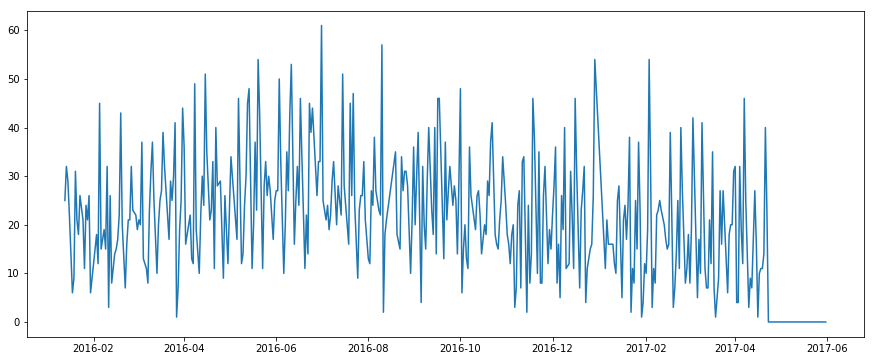

In [10]:
display_df = full_df.copy()
display_df['visit_date'] = pd.to_datetime(display_df['visit_date'])
tdf = display_df[display_df['air_store_id'] == 'air_ba937bf13d40fb24']
# tdf = tdf[tdf['visit_date'].between(datetime.date(2016,6,1), datetime.date(2016,7,1))]
plt.subplots(1,1,figsize=(15,6))
plt.plot(tdf['visit_date'].values, tdf['visitors_o'].values)

## Features

In [11]:
feature_columns = []

def add_features(features):
    if not isinstance(features, list):
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

* store info

In [12]:
# air_genre_name, air_area_name get_dummies
dummies_df = pd.get_dummies(air_store_info[[
    'air_genre_name', 
#     'air_area_name',
]], drop_first=False)
air_store_info[dummies_df.columns] = dummies_df

# add_features([c for c in air_store_info.columns if c.startswith('air_genre_name_')])
add_features(dummies_df.columns.tolist())
add_features(['latitude', 'longitude'])

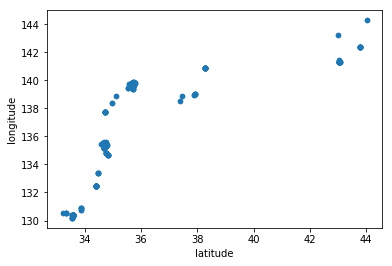

In [13]:
# 店铺位置分布
air_store_info.plot('latitude', 'longitude', kind='scatter')

In [14]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [15]:
full_df = full_df.merge(air_store_info, how='left', on='air_store_id')

* date info

In [16]:
# holiday_flag
date_info['visit_date'] = date_info['calendar_date']
date_info = date_info[['visit_date', 'holiday_flg']]

add_features(['holiday_flg'])

In [17]:
# date property
col_d = pd.to_datetime(date_info['visit_date'])
date_info['visit_month'] = col_d.dt.month
date_info['visit_dayofweek'] = col_d.dt.dayofweek
date_info['visit_days_in_month'] = col_d.dt.days_in_month

add_features(['visit_month', 'visit_dayofweek', 'visit_days_in_month'])

In [18]:
date_info.head()

,visit_date,holiday_flg,visit_month,visit_dayofweek,visit_days_in_month
0,2016-01-01,1,1,4,31
1,2016-01-02,1,1,5,31
2,2016-01-03,1,1,6,31
3,2016-01-04,0,1,0,31
4,2016-01-05,0,1,1,31


In [19]:
full_df = full_df.merge(date_info, how='left', on='visit_date')

* reserve info

In [20]:
hpg_reserve = hpg_reserve.merge(store_id_relation, on='hpg_store_id')

In [21]:
all_reserve = pd.concat([
    hpg_reserve[['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']],
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_datetime', 'reserve_visitors']],
], ignore_index=True)

In [22]:
all_reserve['visit_date'] = all_reserve['visit_datetime'].apply(lambda s: s[:10])
all_reserve['id'] = get_id(all_reserve['air_store_id'], all_reserve['visit_date'])
all_reserve['ahead_reserve_hours'] = (pd.to_datetime(all_reserve['visit_datetime']) - pd.to_datetime(all_reserve['reserve_datetime'])) \
    .apply(lambda x: x.days*24 + x.seconds//3600)
all_reserve['reserve_in_1day'] = (all_reserve['ahead_reserve_hours'] <= 24*1).astype(int)
all_reserve['reserve_in_2day'] = (all_reserve['ahead_reserve_hours'] <= 24*2).astype(int)
all_reserve['reserve_in_3day'] = (all_reserve['ahead_reserve_hours'] <= 24*3).astype(int)
all_reserve['reserve_in_7day'] = (all_reserve['ahead_reserve_hours'] <= 24*7).astype(int)
all_reserve['reserve_in_30day'] = (all_reserve['ahead_reserve_hours'] <= 24*30).astype(int)
all_reserve['reserve_in_1day_visitors'] = all_reserve['reserve_in_1day'] * all_reserve['reserve_visitors']
all_reserve['reserve_in_2day_visitors'] = all_reserve['reserve_in_2day'] * all_reserve['reserve_visitors']
all_reserve['reserve_in_3day_visitors'] = all_reserve['reserve_in_3day'] * all_reserve['reserve_visitors']
all_reserve['reserve_in_7day_visitors'] = all_reserve['reserve_in_7day'] * all_reserve['reserve_visitors']
all_reserve['reserve_in_30day_visitors'] = all_reserve['reserve_in_30day'] * all_reserve['reserve_visitors']
all_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,id,ahead_reserve_hours,reserve_in_1day,reserve_in_2day,reserve_in_3day,reserve_in_7day,reserve_in_30day,reserve_in_1day_visitors,reserve_in_2day_visitors,reserve_in_3day_visitors,reserve_in_7day_visitors,reserve_in_30day_visitors
0,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4,2016-01-01,air_db80363d35f10926_2016-01-01,4,1,1,1,1,1,4,4,4,4,4
1,air_db80363d35f10926,2016-01-02 19:00:00,2016-01-02 14:00:00,2,2016-01-02,air_db80363d35f10926_2016-01-02,5,1,1,1,1,1,2,2,2,2,2
2,air_db80363d35f10926,2016-01-03 18:00:00,2016-01-02 20:00:00,6,2016-01-03,air_db80363d35f10926_2016-01-03,22,1,1,1,1,1,6,6,6,6,6
3,air_db80363d35f10926,2016-01-06 20:00:00,2016-01-04 22:00:00,3,2016-01-06,air_db80363d35f10926_2016-01-06,46,0,1,1,1,1,0,3,3,3,3
4,air_db80363d35f10926,2016-01-11 18:00:00,2016-01-11 14:00:00,2,2016-01-11,air_db80363d35f10926_2016-01-11,4,1,1,1,1,1,2,2,2,2,2


In [23]:
gb = all_reserve.groupby('id')
reserve_df = pd.DataFrame({
    'reserve_count': gb.size(),
    'total_reserve_visitors': gb['reserve_visitors'].sum(),
    'ahead_reserve_hours_median': gb['ahead_reserve_hours'].median(),
    'reserve_in_1day_count': gb['reserve_in_1day'].sum(),
    'reserve_in_2day_count': gb['reserve_in_2day'].sum(),
    'reserve_in_3day_count': gb['reserve_in_3day'].sum(),
    'reserve_in_7day_count': gb['reserve_in_7day'].sum(),
    'reserve_in_30day_count': gb['reserve_in_30day'].sum(),
    'reserve_in_1day_visitors': gb['reserve_in_1day_visitors'].sum(),
    'reserve_in_2day_visitors': gb['reserve_in_2day_visitors'].sum(),
    'reserve_in_3day_visitors': gb['reserve_in_3day_visitors'].sum(),
    'reserve_in_7day_visitors': gb['reserve_in_7day_visitors'].sum(),
    'reserve_in_30day_visitors': gb['reserve_in_30day_visitors'].sum(),
})
reserve_df.head()

,ahead_reserve_hours_median,reserve_count,reserve_in_1day_count,reserve_in_1day_visitors,reserve_in_2day_count,reserve_in_2day_visitors,reserve_in_30day_count,reserve_in_30day_visitors,reserve_in_3day_count,reserve_in_3day_visitors,reserve_in_7day_count,reserve_in_7day_visitors,total_reserve_visitors
id,,,,,,,,,,,,,
air_00a91d42b08b08d9_2016-01-14,77.0,1,0,0,0,0,1,2,0,0,1,2,2
air_00a91d42b08b08d9_2016-01-15,142.0,1,0,0,0,0,1,4,0,0,1,4,4
air_00a91d42b08b08d9_2016-01-16,70.0,1,0,0,0,0,1,2,1,2,1,2,2
air_00a91d42b08b08d9_2016-01-22,82.0,1,0,0,0,0,1,2,0,0,1,2,2
air_00a91d42b08b08d9_2016-01-29,144.0,1,0,0,0,0,1,5,0,0,1,5,5


In [24]:
feats = ['reserve_count', 'total_reserve_visitors', 
         'ahead_reserve_hours_median',
         'reserve_in_1day_count', 'reserve_in_2day_count', 'reserve_in_3day_count', 'reserve_in_7day_count', 'reserve_in_30day_count',
         'reserve_in_1day_visitors', 'reserve_in_2day_visitors', 'reserve_in_3day_visitors', 'reserve_in_7day_visitors', 'reserve_in_30day_visitors',
        ]
full_df = full_df.join(reserve_df, on='id')
full_df[feats] = full_df[feats].fillna(0)
add_features(feats)

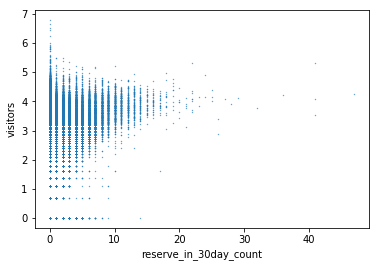

In [25]:
# 可以看到提前预定的人数越多 最后到店用户数越稳定
full_df.plot('reserve_in_30day_count', 'visitors', kind='scatter', s=0.1)

* history visitors stats

In [26]:
# 获取历史统计数据
def get_visitors_stats(df, columns):
    gb = df.groupby(columns)
    col_name = '-'.join(columns) + '-visitors'
    res_df = pd.DataFrame({
#         col_name + '_cnt': gb['visitors'].size(),
        col_name + '_avg': gb['visitors'].mean(),
        col_name + '_max': gb['visitors'].max(),
        col_name + '_min': gb['visitors'].min(),
        col_name + '_q25': gb['visitors'].quantile(0.25),
        col_name + '_q50': gb['visitors'].quantile(0.5),
        col_name + '_q75': gb['visitors'].quantile(0.75),
    })
    return res_df

值得一提的是，加了很多历史属性，但是起主要作用的是['air_store_id', 'visit_dayofweek']

那么，是不是可以说明，访问数受菜系、地区的决定性影响很小，而受该店的历史数据影响很大

那么，直接对每个店铺进行回归，也许也能取得很好的效果

In [27]:
# history visitors stats
group_cols_list = [
    ['air_store_id'],
    ['visit_dayofweek'],
    ['air_store_id', 'visit_dayofweek'],
    ['visit_month'],

    ['air_genre_name'],
    ['air_area_name'],
    ['air_genre_name', 'air_area_name'],
    ['air_genre_name', 'visit_dayofweek'],
    ['air_area_name', 'visit_dayofweek'],
]
for group_cols in group_cols_list:
    stats_df = get_visitors_stats(full_df[is_trn], group_cols)
    full_df = full_df.join(stats_df, on=group_cols).fillna(0)
    add_features(stats_df.columns.tolist())

* show full_df

In [28]:
full_df.head()

,air_store_id,ds_type,id,visit_date,visitors,visitors_o,air_genre_name,air_area_name,latitude,longitude,...,air_genre_name-visit_dayofweek-visitors_min,air_genre_name-visit_dayofweek-visitors_q25,air_genre_name-visit_dayofweek-visitors_q50,air_genre_name-visit_dayofweek-visitors_q75,air_area_name-visit_dayofweek-visitors_avg,air_area_name-visit_dayofweek-visitors_max,air_area_name-visit_dayofweek-visitors_min,air_area_name-visit_dayofweek-visitors_q25,air_area_name-visit_dayofweek-visitors_q50,air_area_name-visit_dayofweek-visitors_q75
0,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-13,2016-01-13,3.258097,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,1.945910,2.639057,3.218876,2.777286,4.976734,0.693147,2.197225,2.890372,3.401197
1,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-14,2016-01-14,3.496508,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.079442,2.639057,3.218876,2.754310,4.700480,0.693147,2.197225,2.833213,3.367296
2,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-15,2016-01-15,3.401197,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.302585,2.944439,3.465736,2.925904,4.812184,0.693147,2.397895,3.044522,3.555348
3,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-16,2016-01-16,3.135494,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,2.484907,3.091042,3.583519,2.730508,4.867534,0.693147,2.079442,2.772589,3.367296
4,air_ba937bf13d40fb24,trn,air_ba937bf13d40fb24_2016-01-18,2016-01-18,1.945910,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.693147,1.791759,2.484907,3.044522,2.450613,5.723585,0.693147,1.791759,2.484907,3.091042


In [29]:
feature_columns

['air_genre_name_Asian',
 'air_genre_name_Bar/Cocktail',
 'air_genre_name_Cafe/Sweets',
 'air_genre_name_Creative cuisine',
 'air_genre_name_Dining bar',
 'air_genre_name_International cuisine',
 'air_genre_name_Italian/French',
 'air_genre_name_Izakaya',
 'air_genre_name_Japanese food',
 'air_genre_name_Karaoke/Party',
 'air_genre_name_Okonomiyaki/Monja/Teppanyaki',
 'air_genre_name_Other',
 'air_genre_name_Western food',
 'air_genre_name_Yakiniku/Korean food',
 'latitude',
 'longitude',
 'holiday_flg',
 'visit_month',
 'visit_dayofweek',
 'visit_days_in_month',
 'reserve_count',
 'total_reserve_visitors',
 'ahead_reserve_hours_median',
 'reserve_in_1day_count',
 'reserve_in_2day_count',
 'reserve_in_3day_count',
 'reserve_in_7day_count',
 'reserve_in_30day_count',
 'reserve_in_1day_visitors',
 'reserve_in_2day_visitors',
 'reserve_in_3day_visitors',
 'reserve_in_7day_visitors',
 'reserve_in_30day_visitors',
 'air_store_id-visitors_avg',
 'air_store_id-visitors_max',
 'air_store_id-vi

## Save Features

In [30]:
# save_features(full_df, feature_columns)
# full_df, feature_columns = read_features()

## Preprocessing

In [31]:
trn_df = full_df[is_trn]
tst_df = full_df[is_tst]

is_val = trn_df['visit_date'].between('2017-02-01', '2017-04-22')

X = trn_df[feature_columns]
y = trn_df[label_col]
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
# X_trn, X_val, y_trn, y_val = X[is_val], X[~is_val], y[is_val], y[~is_val]

X_tst = tst_df[feature_columns]

## LightGBM

In [32]:
trn_lgb = lgb.Dataset(X_trn.values, y_trn)
val_lgb = lgb.Dataset(X_val.values, y_val, reference=trn_lgb)

In [33]:
params = {
    'boosting': 'gbdt',
    'application': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'seed': 0,
    'reg_alpha': 0.1,
}
lgbm = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)

[1]	training's rmse: 0.784733	valid_1's rmse: 0.781374
Training until validation scores don't improve for 20 rounds.
[2]	training's rmse: 0.762613	valid_1's rmse: 0.759405
[3]	training's rmse: 0.742228	valid_1's rmse: 0.739179
[4]	training's rmse: 0.723149	valid_1's rmse: 0.720248
[5]	training's rmse: 0.705663	valid_1's rmse: 0.702906
[6]	training's rmse: 0.68954	valid_1's rmse: 0.686949
[7]	training's rmse: 0.67455	valid_1's rmse: 0.672097
[8]	training's rmse: 0.660546	valid_1's rmse: 0.658234
[9]	training's rmse: 0.647575	valid_1's rmse: 0.645376
[10]	training's rmse: 0.635706	valid_1's rmse: 0.633616
[11]	training's rmse: 0.62488	valid_1's rmse: 0.622913
[12]	training's rmse: 0.614941	valid_1's rmse: 0.613087
[13]	training's rmse: 0.60567	valid_1's rmse: 0.603924
[14]	training's rmse: 0.597205	valid_1's rmse: 0.595563
[15]	training's rmse: 0.58948	valid_1's rmse: 0.587946
[16]	training's rmse: 0.582307	valid_1's rmse: 0.580877
[17]	training's rmse: 0.575864	valid_1's rmse: 0.574522


[147]	training's rmse: 0.500139	valid_1's rmse: 0.502019
[148]	training's rmse: 0.5001	valid_1's rmse: 0.502001
[149]	training's rmse: 0.500072	valid_1's rmse: 0.501978
[150]	training's rmse: 0.50004	valid_1's rmse: 0.501971
[151]	training's rmse: 0.500018	valid_1's rmse: 0.501956
[152]	training's rmse: 0.499985	valid_1's rmse: 0.501952
[153]	training's rmse: 0.499959	valid_1's rmse: 0.501937
[154]	training's rmse: 0.499929	valid_1's rmse: 0.501917
[155]	training's rmse: 0.499906	valid_1's rmse: 0.501917
[156]	training's rmse: 0.499877	valid_1's rmse: 0.501913
[157]	training's rmse: 0.499846	valid_1's rmse: 0.501914
[158]	training's rmse: 0.499795	valid_1's rmse: 0.501862
[159]	training's rmse: 0.499783	valid_1's rmse: 0.501859
[160]	training's rmse: 0.499735	valid_1's rmse: 0.501819
[161]	training's rmse: 0.499698	valid_1's rmse: 0.501791
[162]	training's rmse: 0.499666	valid_1's rmse: 0.501771
[163]	training's rmse: 0.499607	valid_1's rmse: 0.501711
[164]	training's rmse: 0.499579	va

[292]	training's rmse: 0.496129	valid_1's rmse: 0.499758
[293]	training's rmse: 0.496104	valid_1's rmse: 0.499743
[294]	training's rmse: 0.496083	valid_1's rmse: 0.499744
[295]	training's rmse: 0.496053	valid_1's rmse: 0.499726
[296]	training's rmse: 0.496037	valid_1's rmse: 0.499741
[297]	training's rmse: 0.496022	valid_1's rmse: 0.499749
[298]	training's rmse: 0.496011	valid_1's rmse: 0.499745
[299]	training's rmse: 0.495986	valid_1's rmse: 0.499728
[300]	training's rmse: 0.495954	valid_1's rmse: 0.499702
[301]	training's rmse: 0.495932	valid_1's rmse: 0.499687
[302]	training's rmse: 0.495897	valid_1's rmse: 0.499652
[303]	training's rmse: 0.495873	valid_1's rmse: 0.499638
[304]	training's rmse: 0.495861	valid_1's rmse: 0.499656
[305]	training's rmse: 0.495838	valid_1's rmse: 0.499644
[306]	training's rmse: 0.495807	valid_1's rmse: 0.499628
[307]	training's rmse: 0.495793	valid_1's rmse: 0.499636
[308]	training's rmse: 0.495784	valid_1's rmse: 0.499638
[309]	training's rmse: 0.495778

[443]	training's rmse: 0.493239	valid_1's rmse: 0.498599
[444]	training's rmse: 0.493236	valid_1's rmse: 0.498603
[445]	training's rmse: 0.493219	valid_1's rmse: 0.498627
[446]	training's rmse: 0.493199	valid_1's rmse: 0.498611
[447]	training's rmse: 0.493191	valid_1's rmse: 0.498605
[448]	training's rmse: 0.493166	valid_1's rmse: 0.498579
[449]	training's rmse: 0.493137	valid_1's rmse: 0.498598
[450]	training's rmse: 0.493118	valid_1's rmse: 0.498586
[451]	training's rmse: 0.4931	valid_1's rmse: 0.498571
[452]	training's rmse: 0.493078	valid_1's rmse: 0.498558
[453]	training's rmse: 0.493023	valid_1's rmse: 0.498515
[454]	training's rmse: 0.493013	valid_1's rmse: 0.498515
[455]	training's rmse: 0.493006	valid_1's rmse: 0.498516
[456]	training's rmse: 0.492984	valid_1's rmse: 0.498516
[457]	training's rmse: 0.49295	valid_1's rmse: 0.498499
[458]	training's rmse: 0.492938	valid_1's rmse: 0.498492
[459]	training's rmse: 0.492917	valid_1's rmse: 0.498477
[460]	training's rmse: 0.4929	vali

[591]	training's rmse: 0.491124	valid_1's rmse: 0.498008
[592]	training's rmse: 0.491104	valid_1's rmse: 0.498002
[593]	training's rmse: 0.491089	valid_1's rmse: 0.497996
[594]	training's rmse: 0.491064	valid_1's rmse: 0.497983
[595]	training's rmse: 0.49105	valid_1's rmse: 0.497986
[596]	training's rmse: 0.491034	valid_1's rmse: 0.49798
[597]	training's rmse: 0.491014	valid_1's rmse: 0.497978
[598]	training's rmse: 0.490994	valid_1's rmse: 0.49798
[599]	training's rmse: 0.490984	valid_1's rmse: 0.497982
[600]	training's rmse: 0.490958	valid_1's rmse: 0.497958
[601]	training's rmse: 0.490949	valid_1's rmse: 0.497955
[602]	training's rmse: 0.490935	valid_1's rmse: 0.497951
[603]	training's rmse: 0.490921	valid_1's rmse: 0.497962
[604]	training's rmse: 0.490892	valid_1's rmse: 0.497944
[605]	training's rmse: 0.490879	valid_1's rmse: 0.497938
[606]	training's rmse: 0.490863	valid_1's rmse: 0.49793
[607]	training's rmse: 0.49085	valid_1's rmse: 0.497931
[608]	training's rmse: 0.490814	vali

[737]	training's rmse: 0.489172	valid_1's rmse: 0.497637
[738]	training's rmse: 0.489157	valid_1's rmse: 0.497638
[739]	training's rmse: 0.48915	valid_1's rmse: 0.497646
[740]	training's rmse: 0.489131	valid_1's rmse: 0.497636
[741]	training's rmse: 0.489128	valid_1's rmse: 0.497637
[742]	training's rmse: 0.489119	valid_1's rmse: 0.497638
[743]	training's rmse: 0.489113	valid_1's rmse: 0.497635
[744]	training's rmse: 0.489105	valid_1's rmse: 0.497636
[745]	training's rmse: 0.489076	valid_1's rmse: 0.497625
[746]	training's rmse: 0.489067	valid_1's rmse: 0.497621
[747]	training's rmse: 0.489052	valid_1's rmse: 0.497601
[748]	training's rmse: 0.489038	valid_1's rmse: 0.497602
[749]	training's rmse: 0.489035	valid_1's rmse: 0.497604
[750]	training's rmse: 0.489029	valid_1's rmse: 0.497614
[751]	training's rmse: 0.489015	valid_1's rmse: 0.49763
[752]	training's rmse: 0.489008	valid_1's rmse: 0.497623
[753]	training's rmse: 0.489004	valid_1's rmse: 0.497629
[754]	training's rmse: 0.488993	v

In [34]:
imp_df = pd.DataFrame([lgbm.feature_importance()], 
                      columns=feature_columns, 
                      index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
visit_month,853
air_store_id-visit_dayofweek-visitors_avg,794
air_store_id-visit_dayofweek-visitors_max,710
visit_month-visitors_avg,698
air_store_id-visitors_max,644
air_store_id-visit_dayofweek-visitors_q25,637
visit_month-visitors_max,563
total_reserve_visitors,528
air_store_id-visit_dayofweek-visitors_q75,518
air_store_id-visitors_avg,428


## XGBoost

In [35]:
trn_xgb = xgb.DMatrix(X_trn, y_trn)
val_xgb = xgb.DMatrix(X_val, y_val)

In [36]:
# params = {
#     'booster': 'gbtree',
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'learning_rate': 0.05,
#     'max_depth': 5,
#     'colsample_bytree': 0.8,
#     'subsample': 0.5,
#     'seed': 0,
# }
# xgbm = xgb.train(params, trn_xgb, 1000, [(trn_xgb, 'trn'), (val_xgb, 'val')], early_stopping_rounds=20)

## RandomForestRegressor

In [37]:
rfr = RandomForestRegressor()

In [38]:
gs_param = {
    'n_estimators': [100,200,300],
    'max_depth': [4],
}

In [39]:
rfr_gs = GridSearchCV(rfr, gs_param, scoring='neg_mean_squared_error')

In [40]:
# rfr_gs.fit(X, y)

In [41]:
# plot_grid_search_result(gs_rf)

## predict

In [42]:
pred_df = pd.DataFrame({
    'lgbm': lgbm.predict(X_tst),
#     'xgbm': xgbm.predict(xgb.DMatrix(X_tst)),
})

In [43]:
pred_df

,lgbm
0,0.900769
1,3.024311
2,3.119990
3,3.322663
4,3.432096
5,3.624016
6,2.653887
7,0.900769
8,3.076241
9,3.176332


In [44]:
pred_res = pred_df.mean(axis=1)
pred_res = pred_res.apply(np.expm1)
# test
pred_res = pred_res.apply(lambda x: np.around(x, 0))

In [45]:
res_df = pd.DataFrame({
    output_id_col: tst_df[output_id_col].values,
    output_label_col: pred_res,
})
res_df[[output_id_col, output_label_col]].to_csv(submission_path, index=False)